In [1]:
import torch

# Check GPU availability (optional)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
print("Number of GPUs:", torch.cuda.device_count())
print('Torch version:', torch.__version__)

Using device: cuda
Number of GPUs: 1
Torch version: 2.5.1+cu124


# Dataset preparation

In [2]:
import os


def read_text(file_id, base_path='data/EN/raw-documents'):
    with open(os.path.join(base_path, f'{file_id}'), 'r', encoding='utf-8') as f:
        return f.read()

We start by preparing the dataset by loading the txt file. We then transform the narratives and subnarratives string into lists for further manipulation

# Choosing the model

In [ ]:
from transformers import LlamaTokenizer
from transformers import (
    LlamaTokenizer,
    LlamaForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    AutoTokenizer, AutoModel,
)

In [ ]:
HF_ACCESS_TOKEN = os.getenv('HF_TOKEN')
print(HF_ACCESS_TOKEN)

# Tokenization

# Configure Unsloth

We quantize the model

In [3]:
from unsloth import tokenizer_utils
def do_nothing(*args, **kwargs):
    pass
tokenizer_utils.fix_untrained_tokens = do_nothing

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/home/twoface/PHD-Track/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth Zoo will now patch everything to make training faster!


In [4]:
import torch
major_version, minor_version = torch.cuda.get_device_capability()
print(f"Major: {major_version}, Minor: {minor_version}")
from datasets import load_dataset
import datasets
from trl import SFTTrainer
import pandas as pd
import numpy as np
import os
import pandas as pd
import numpy as np
from unsloth import FastLanguageModel
from trl import SFTTrainer
from transformers import TrainingArguments, Trainer
from typing import Tuple
import warnings
from typing import Any, Dict, List, Union
from transformers import DataCollatorForLanguageModeling
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# os.environ["WANDB_DISABLED"] = "true"
import torch, gc
gc.collect()
torch.cuda.empty_cache()


max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+


Major: 8, Minor: 9


In [5]:
# model_name = "unsloth/Qwen2-7B-bnb-4bit";load_in_4bit = True
model_name = "unsloth/Llama-3.2-1B-Instruct-bnb-4bit";load_in_4bit = True,

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name,load_in_4bit = load_in_4bit,
    max_seq_length = max_seq_length,
    dtype = dtype,
)

==((====))==  Unsloth 2025.1.5: Fast Llama patching. Transformers: 4.48.0.
   \\   /|    GPU: NVIDIA GeForce RTX 4070 Laptop GPU. Max memory: 7.996 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [6]:
yes_token_id = tokenizer.encode("Yes", add_special_tokens=False)[0]
no_token_id = tokenizer.encode("No", add_special_tokens=False)[0]
# keep only the yes and no tokens from lm_head
par = torch.nn.Parameter(torch.vstack([model.lm_head.weight[no_token_id, :], model.lm_head.weight[yes_token_id, :]]))
print(par.shape)
print(model.lm_head.weight.shape)
model.lm_head.weight = par

torch.Size([2, 2048])
torch.Size([128256, 2048])


In [7]:
from peft import LoftQConfig

model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = [
        "lm_head", # can easily be trained because it has only 2 tokens
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    # use_rslora = True,  # We support rank stabilized LoRA
    # init_lora_weights = 'loftq',
    loftq_config = LoftQConfig(loftq_bits = 4, loftq_iter = 1), # And LoftQ
)
print("trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

/home/twoface/PHD-Track/.venv/lib/python3.12/site-packages/peft/tuners/lora/config.py:455: UserWarning: `loftq_config` specified but will be ignored when `init_lora_weights` is not 'loftq'.
  warnings.warn("`loftq_config` specified but will be ignored when `init_lora_weights` is not 'loftq'.")


Unsloth: Offloading output_embeddings to disk to save VRAM


/home/twoface/PHD-Track/.venv/lib/python3.12/site-packages/unsloth/models/_utils.py:748: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  offloaded_W = torch.load(filename, map

Unsloth: Training lm_head in mixed precision to save VRAM
trainable parameters: 11276288


In [8]:
df = pd.read_csv('data/EN/subtask-2-annotations.txt', delimiter='\t', header=None)
df.columns = ['file_id', 'narratives', 'subnarratives']
df['text'] = df['file_id'].apply(read_text)

In [9]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
test_df

,file_id,narratives,subnarratives,text
198,EN_UA_300079.txt,URW: Discrediting Ukraine;URW: Discrediting th...,URW: Discrediting Ukraine: Discrediting Ukrain...,Lavrov: West Is Demonstrating Totalitarian Int...
349,EN_UA_028520.txt,URW: Overpraising the West,URW: Overpraising the West: The West belongs i...,EU’s top diplomat angry at Hungarian FM for la...
33,EN_UA_101996.txt,URW: Speculating war outcomes;URW: Discreditin...,URW: Speculating war outcomes: Other;URW: Disc...,Boris Johnson demands Putin ‘steps back from t...
208,EN_UA_021270.txt,URW: Speculating war outcomes;URW: Discreditin...,URW: Speculating war outcomes: Other;URW: Disc...,"Ukraine's Fate Will Be Decided In Coming Year,..."
93,EN_CC_200285.txt,Other,Other,George W. Bush and Barack Obama to Hold Back-t...
...,...,...,...,...
249,EN_CC_100016.txt,Other,Other,Heavy storms hit southern Europe causing huge ...
225,EN_CC_300028.txt,CC: Criticism of institutions and authorities,CC: Criticism of institutions and authorities:...,Lawsuit filed in bid to halt Alaska oil drilli...
368,EN_CC_200009.txt,CC: Criticism of climate movement;CC: Criticis...,CC: Criticism of climate movement: Ad hominem ...,Climate Hypocrisy Exposed: EV Battery Producti...
175,EN_CC_200134.txt,CC: Hidden plots by secret schemes of powerful...,CC: Hidden plots by secret schemes of powerful...,Greece: 13 Muslim migrants charged with arson ...


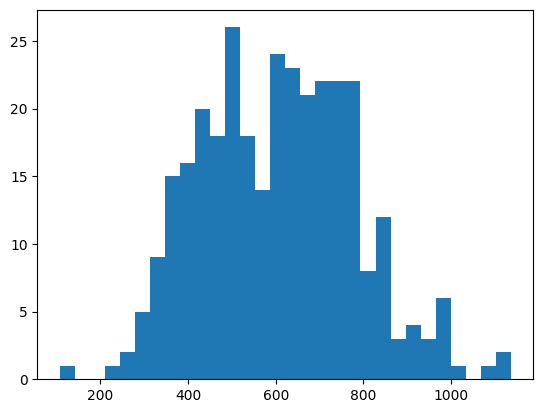

In [10]:
token_counts = [len(tokenizer.encode(x)) for x in train_df.text]
# plot the token counts
a = plt.hist(token_counts, bins=30)

In [29]:
def prepare_dataset_for_narrative(df, narrative):
    new_df = df
    # label is 1 if the narrative is in the list of narratives, 0 otherwise
    new_df['label'] = new_df['narratives'].apply(lambda x: 1 if narrative in x else 0)
    new_df = new_df[['text', 'label']]
    dataset = datasets.Dataset.from_pandas(new_df, preserve_index=False)
    return dataset

In [30]:
train_dataset = prepare_dataset_for_narrative(train_df, 'CC: Criticism of climate movement')
test_dataset = prepare_dataset_for_narrative(test_df, 'CC: Criticism of climate movement')

In [13]:
# this custom collator is needed to change the sequence labels from yes_token_id and no_token_id to 1 and 0. It also trains only on the last token of the sequence.
class DataCollatorForLastTokenLM(DataCollatorForLanguageModeling):
    def __init__(
            self,
            *args,
            mlm: bool = False,
            ignore_index: int = -100,
            **kwargs,
    ):
        super().__init__(*args, mlm=mlm, **kwargs)
        self.ignore_index = ignore_index

    def torch_call(self, examples: List[Union[List[int], Any, Dict[str, Any]]]) -> Dict[str, Any]:
        batch = super().torch_call(examples)

        for i in range(len(examples)):
            # Find the last non-padding token
            last_token_idx = (batch["labels"][i] != self.ignore_index).nonzero()[-1].item()
            # Set all labels to ignore_index except for the last token
            batch["labels"][i, :last_token_idx] = self.ignore_index
            # The old labels for the Yes and No tokens need to be mapped to 1 and 0
            batch["labels"][i, last_token_idx] = 1 if batch["labels"][i, last_token_idx] == yes_token_id else 0


        return batch
collator = DataCollatorForLastTokenLM(tokenizer=tokenizer)

In [14]:
# Define the specific class name and definition
class_name = "CC: Criticism of climate movement"
class_definition = ("Definition: Statements that challenge the motives, integrity, or impact of the climate movement. "
                    "Example: 'It is a feature of the scientific establishment to overemphasize speculations of climate collapse and silence critics.'")


prompt = """You are a classification model, and you are asked to determine whether a text has the following class {}.
Here is a definition of the class: {}
Here is the text you need to classify:
{}

Does this text contain the class {}? Answer with "Yes" or "No".

SOLUTION
The correct answer is: "{}"""

positivelabel = "Yes"
negativelabel = "No"


def formatting_prompts_func(dataset_):
    # this is to fix an issue with a certain transformers version, you might not need this
    if isinstance(dataset_['text'], str):
        if model_name.lower().__contains__("qwen"):
            return [""]*100
        elif model_name.lower().__contains__("llama"):
            return " "
        else:
            return " "

    texts = []
    for i in range(len(dataset_['text'])):
        t = dataset_['text'][i]
        label = positivelabel if dataset_['label'][i] == 1 else negativelabel
        text = prompt.format(class_name, class_definition, t, class_name, label)


        texts.append(text)
    return texts

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # not needed because group_by_length is True
    args = TrainingArguments(
        per_device_train_batch_size = 32,
        gradient_accumulation_steps = 1,
        warmup_steps = 10,
        learning_rate = 1e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "cosine",
        seed = 3407,
        output_dir = "outputs",
        num_train_epochs = 1,
        # report_to = "wandb",
        report_to = "none",
        group_by_length = True,
    ),
    formatting_func=formatting_prompts_func,
    data_collator=collator,
)

Map (num_proc=2): 100%|██████████| 319/319 [00:00<00:00, 329.68 examples/s]


In [15]:
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA GeForce RTX 4070 Laptop GPU. Max memory = 7.996 GB.
1.012 GB of memory reserved.


In [16]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 319 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 32 | Gradient Accumulation steps = 1
\        /    Total batch size = 32 | Total steps = 10
 "-____-"     Number of trainable parameters = 11,276,288


Step,Training Loss
1,0.923300
2,0.715600
3,0.913400
4,0.695100
5,0.720100
6,0.305600
7,0.401000
8,0.569500
9,0.329400
10,0.019900


In [17]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

87.6129 seconds used for training.
1.46 minutes used for training.
Peak reserved memory = 5.451 GB.
Peak reserved memory for training = 4.439 GB.
Peak reserved memory % of max memory = 68.172 %.
Peak reserved memory for training % of max memory = 55.515 %.


In [18]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 2048, padding_idx=128004)
        (layers): ModuleList(
          (0-15): 16 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lor

In [19]:
saved_name = f"lora_model_{model_name.replace('/','_')}"
model.save_pretrained(saved_name)

In [31]:
from collections import defaultdict
import torch.nn.functional as F

tokenized_inputs = []
for i in range(len(test_df['text'])):
    text = test_df['text'].iloc[i]
    test_str = prompt.format(class_name, class_definition, text, class_name , "")
    tokenized_input = tokenizer(test_str, return_tensors="pt", add_special_tokens=False)
    tokenized_inputs.append((tokenized_input, test_str, test_df['label'].iloc[i]))

# Sort by tokenized length
tokenized_inputs.sort(key=lambda x: x[0]['input_ids'].shape[1])

# Step 2: Group the inputs by their tokenized length
grouped_inputs = defaultdict(list)
for tokenized_input, test_str, label in tokenized_inputs:
    length = tokenized_input['input_ids'].shape[1]
    grouped_inputs[length].append((tokenized_input, test_str, label))

# Step 3: Process each group in batches of 64
batch_size = 64
all_outputs = []
all_strings = []
all_labels = []

In [32]:
from tqdm import tqdm
for length, group in tqdm(grouped_inputs.items()):
    for i in range(0, len(group), batch_size):
        batch = group[i:i+batch_size]
        batch_inputs = [item[0] for item in batch]
        batch_strings = [item[1] for item in batch]
        batch_labels = [item[2] for item in batch]

        # Concatenate the batch inputs
        input_ids = torch.cat([item['input_ids'] for item in batch_inputs], dim=0).to("cuda")
        attention_mask = torch.cat([item['attention_mask'] for item in batch_inputs], dim=0).to("cuda")

        # Forward pass
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            # print(outputs.logits[:, -1].shape)
        
        # Get logits for the first token prediction (assuming binary classification)
        logits = outputs.logits[:, -1, :2]  # Only consider logits for 0 and 1
        
        # Apply softmax
        probabilities = F.softmax(logits, dim=-1)
        
        # Get predictions
        predictions = torch.argmax(probabilities, dim=-1)
        
        all_outputs.extend(predictions.cpu().numpy())
        all_labels.extend(batch_labels)
        all_strings.extend(batch_strings)

100%|██████████| 78/78 [00:08<00:00,  8.94it/s]


In [33]:
# Step 4: Do the label assignment
correct = 0
total = 0

for i in range(len(all_outputs)):
    pred = str(all_outputs[i])
    label = str(all_labels[i])
    if i > len(all_outputs) - 25:
        print(f"{i}: text: {all_strings[i]}\n pred: {pred} label: {label}\n")

    if pred == label:
        correct += 1
    total += 1

print(f"Correct: {correct} Total: {total} Accuracy: {correct/total}")

56: text: You are a classification model, and you are asked to determine whether a text has the following class CC: Criticism of climate movement.
Here is a definition of the class: Definition: Statements that challenge the motives, integrity, or impact of the climate movement. Example: 'It is a feature of the scientific establishment to overemphasize speculations of climate collapse and silence critics.'
Here is the text you need to classify:
Armistice Day and the Empire: A Name Change and the Catastrophe that Followed 

 In 1954, the US Congress renamed Armistice Day to Veterans Day. The stated reason was to remember all generations of US veterans, not just veterans from the First World War. Congress advanced this rationale on the disingenuous notion that Armistice Day’s purpose was a celebration of veterans. It was not. Armistice Day’s purpose was to serve as a reminder of the horrors of the First World War and carry forward the declaration of those veterans of Never Again.

For a U